# Box Office Film Analysis


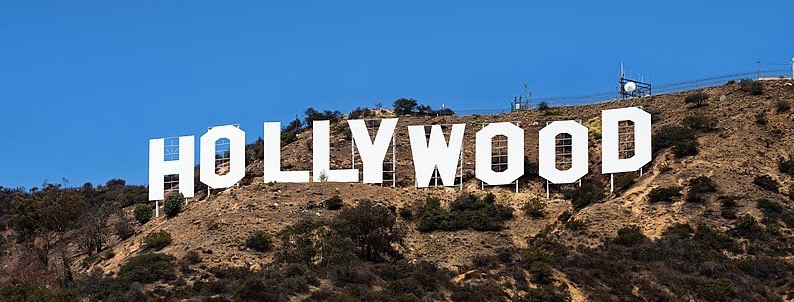

# Overview

Our data analytics firm has been hired by the Flatiron Productions, to analyze which films perform the best at the Box Office. This project analyses a data set that combines data from [IMBd](https://www.imdb.com/)
 and [The Numbers](https://www.the-numbers.com/movie/), to assess which movies have the most success worldwide. We will make recommendations based on genre, production budget and seasonal trends based from our analysis results.




# Business Understanding

Flatiron Productions wants to invest in a new film studio. Having no expereince in the film industry the company has hired our data analytics firm to explore what makes for a succesful film and to make recommendations on a low risk investment strategy to break into the film industry. Our analysis will allow Flatiron Productions to create a new film studio with a clear understanding of what type of movies to produce, what production budget tier they should focus on and when to release them.

# The Data 

<img src="images/d90etr2uv2t9idnbcshcl9eh3p-e60d36ec5ba6ce6543b246ef0041c504.png" width="45%"/>

The data we used for our analysis combined two data sets. The first data set was pulled from *IMDb* and includes movie information and ratings from 1915 to 2019. The second data set we used was pulled from *The Numbers*, and includes information about budgets and gross revenues for each movie. Our merged, working data set will focus on movie genre, production budget, month of release and an engineered profit ratio. 



## Data Preparation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import gauss, seed
from scipy import stats
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from matplotlib import style
style.use('ggplot')


%matplotlib inline

In [2]:
#read in 'The Numbers' budget data set
budget = pd.read_csv('zippedData/tn.movie_budgets.csv')

In [3]:
#visualise the first 5 rows of the data frame
budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [4]:
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### Data Cleaning - Movie Budgets Data Set

We first conducted EDA and cleaning on the movie budgets data set:

- Converted 'release date' column to a datetime object
- Removed unecessary punctuation and dollar signs
- Converted all budget and revenue values to integers

In [5]:
#change dates to datetime objects
budget['release_date'] = pd.to_datetime(budget['release_date'])

In [6]:
#remove commas from gross figures
budget = budget.replace(',','', regex=True)

In [7]:
#removing '$' from:
budget['production_budget']= budget['production_budget'].str[1:]
budget['domestic_gross'] = budget['domestic_gross'].str[1:]
budget['worldwide_gross'] = budget['worldwide_gross'].str[1:]

In [8]:
#using astype() to convert to 'int'
budget[['production_budget', 'domestic_gross', 'worldwide_gross']] = budget[['production_budget', 
                                                                             'domestic_gross', 'worldwide_gross']].astype(int)

In [9]:
#sanity check
budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 271.2+ KB


### Filtering the data to include only movies released during or after 2010
We filtered our data set down to include only movies released between 2010 to 2019 (the most recent release date in original data set). This was to account for the rise of streaming services in the late 2000s that completely changed the way movies were released and consumed by the public.

In [10]:
#convert to datetime object & narrow down to include only movies made after 2010
budget['year'] = budget['release_date'].dt.year
budget_recent = budget.loc[budget['year']>2010]


### Feature Engineering
#### We created a 'profitc ratio' variable to allow for more meaningul business analysis and comparison between different movies.

In [11]:
#Create a new column to determine 'ROI' based on gross revenue divided by production cost
budget_recent["profit_ratio"]= budget_recent['worldwide_gross']/budget_recent['production_budget']

<ipython-input-11-9fd179ea24f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  budget_recent["profit_ratio"]= budget_recent['worldwide_gross']/budget_recent['production_budget']


In [12]:
budget_recent['profit_ratio'].describe()

count    1920.000000
mean        3.285546
std        11.055955
min         0.000000
25%         0.200260
50%         1.613252
75%         3.635941
max       416.564740
Name: profit_ratio, dtype: float64

Here we notice a major outlier with a profit ratio of 416.

### Removing significant outliers
Using our 'profit ratio' variable, we dropped a major outlier, "The Gallows", that was propping up some of our statistical tests.

In [89]:
#dropping significant outliers
budget_recent.drop(budget_recent[budget_recent['profit_ratio'] == 416.564740].index, inplace = True)

/Users/jf/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Merging the Budget dataframe with the SQL IMDB dataset.
As mentioned above, here we merge our cleaned budget data set with the IMBd data set that was pulled from SQL. We converted the SQL data set into a pandas data frame to merge it with our budget data set.

In [72]:
#imports and connect to SQL
import sqlite3
import pandasql
import matplotlib.pyplot as plt


conn = sqlite3.connect('zippedData/im.db')

In [90]:
#creating a dataframe with relevant information from IMDB database
imdb_ratings = pd.read_sql(
    """
    SELECT basics.movie_id, basics.primary_title, basics.original_title, 
    basics.runtime_minutes, basics.genres, ratings.averagerating, ratings.numvotes
    FROM movie_basics as basics
        JOIN movie_ratings as ratings
            USING(movie_id)
    """, conn
)

In [91]:
imdb_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   runtime_minutes  66236 non-null  float64
 4   genres           73052 non-null  object 
 5   averagerating    73856 non-null  float64
 6   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 3.9+ MB


In [92]:
imdb_ratings.head()

,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,80.0,"Comedy,Drama,Fantasy",6.5,119


In [93]:
#renaming the budget data frame to 'budget_cleaned'
budget_cleaned = budget_recent

#### To avoid duplicates created by the merging of the data sets, we dropped all duplicated from both sets before merging.

In [94]:
#removing duplicates from dataframe before merging.
imdb_ratings = imdb_ratings.drop_duplicates(subset=['primary_title'])
budget_cleaned = budget_cleaned.drop_duplicates(subset=['movie'])

In [95]:
#merge imdb data with our movie budget data
all_recent = pd.merge(budget_cleaned, imdb_ratings, left_on='movie', right_on='primary_title', how='inner')
all_recent

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit_ratio,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,2.546673,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624
1,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019,0.427892,tt6565702,Dark Phoenix,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451
2,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,4.243841,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594
3,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,2018,6.827114,tt4154756,Avengers: Infinity War,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926
4,9,2017-11-17,Justice League,300000000,229024295,655945209,2017,2.186484,tt0974015,Justice League,Justice League,120.0,"Action,Adventure,Fantasy",6.5,329135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,59,2011-11-25,The Ridges,17300,0,0,2011,0.000000,tt1781935,The Ridges,The Ridges,89.0,"Drama,Horror,Thriller",2.9,127
1586,62,2014-12-31,Stories of Our Lives,15000,0,0,2014,0.000000,tt3973612,Stories of Our Lives,Stories of Our Lives,60.0,Drama,7.5,85
1587,73,2012-01-13,Newlyweds,9000,4584,4584,2012,0.509333,tt1880418,Newlyweds,Newlyweds,95.0,"Comedy,Drama",6.4,1436
1588,78,2018-12-31,Red 11,7000,0,0,2018,0.000000,tt7837402,Red 11,Red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43


In [96]:
#duplicates sanity check
all_recent['movie'].duplicated().value_counts()

False    1590
Name: movie, dtype: int64

In [97]:
all_recent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1590 entries, 0 to 1589
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1590 non-null   int64         
 1   release_date       1590 non-null   datetime64[ns]
 2   movie              1590 non-null   object        
 3   production_budget  1590 non-null   int64         
 4   domestic_gross     1590 non-null   int64         
 5   worldwide_gross    1590 non-null   int64         
 6   year               1590 non-null   int64         
 7   profit_ratio       1590 non-null   float64       
 8   movie_id           1590 non-null   object        
 9   primary_title      1590 non-null   object        
 10  original_title     1590 non-null   object        
 11  runtime_minutes    1572 non-null   float64       
 12  genres             1588 non-null   object        
 13  averagerating      1590 non-null   float64       
 14  numvotes

#### Noticing a few null values we decided to drop those null values to have a fully cleaned dataframe to work with.

In [98]:
#dropping all null values from merged dataframe
all_recent = all_recent.dropna()

### More Feature Engineering
Here we filter our data set by creating a 'budget_class' variable that categorizes movies based on production budget. Our budget classes were based on [IATSE's](https://www.wrapbook.com/blog/film-budget-tiers)
 budget tier system that states that any movie with a production budget over 15 million dollars no longer qualifies for the IATSE "Low Budget Agreement". As such, our 'low_budget' class includes all movies with a budget of 15 million dollars or less and our 'high_budget' class includes all movies with budgets exceeeding 15 million dollars.

In [99]:
#create a column that sorts movies based on 'high' or 'low' production budget
conditions = [
    (all_recent['production_budget'] <= 15000000),
    (all_recent['production_budget'] > 15000000)]

#create a list of the values we want to assign for each condition
values = ['low_budget', 'high_budget']

#create a new column and use np.select to assign values to it using our lists as arguments
all_recent['budget_class'] = np.select(conditions, values)
all_recent

<ipython-input-99-068bcbac2e14>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_recent['budget_class'] = np.select(conditions, values)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit_ratio,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,budget_class
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,2.546673,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624,high_budget
1,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019,0.427892,tt6565702,Dark Phoenix,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451,high_budget
2,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,4.243841,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594,high_budget
3,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,2018,6.827114,tt4154756,Avengers: Infinity War,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926,high_budget
4,9,2017-11-17,Justice League,300000000,229024295,655945209,2017,2.186484,tt0974015,Justice League,Justice League,120.0,"Action,Adventure,Fantasy",6.5,329135,high_budget
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,59,2011-11-25,The Ridges,17300,0,0,2011,0.000000,tt1781935,The Ridges,The Ridges,89.0,"Drama,Horror,Thriller",2.9,127,low_budget
1586,62,2014-12-31,Stories of Our Lives,15000,0,0,2014,0.000000,tt3973612,Stories of Our Lives,Stories of Our Lives,60.0,Drama,7.5,85,low_budget
1587,73,2012-01-13,Newlyweds,9000,4584,4584,2012,0.509333,tt1880418,Newlyweds,Newlyweds,95.0,"Comedy,Drama",6.4,1436,low_budget
1588,78,2018-12-31,Red 11,7000,0,0,2018,0.000000,tt7837402,Red 11,Red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,low_budget


<br>

# ANALYSIS - 3 Recommendations



#  1. Genre: Horror

We first focused on the Horror genre as 14 of the 20 movies with the highest profit ratio were Horror movies. We created a new boolean column to be able to select for only horror movies from a our dataset.

In [101]:
#filtering for 20 movies with highest profit ratio
all_recent.sort_values(by= "profit_ratio", ascending=False)[:20]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit_ratio,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,budget_class
1403,12,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,101.759490,tt1560985,The Devil Inside,The Devil Inside,83.0,Horror,4.2,33522,low_budget
1360,63,2011-04-01,Insidious,1500000,54009150,99870886,2011,66.580591,tt1591095,Insidious,Insidious,103.0,"Horror,Mystery,Thriller",6.9,254197,low_budget
1404,14,2015-04-17,Unfriended,1000000,32789645,64364198,2015,64.364198,tt3713166,Unfriended,Unfriended,83.0,"Horror,Mystery,Thriller",5.6,62043,low_budget
1134,50,2017-01-20,Split,5000000,138141585,278964806,2017,55.792961,tt2660118,Split,Split,90.0,"Comedy,Romance,Sport",2.9,557,low_budget
1133,49,2017-02-24,Get Out,5000000,176040665,255367951,2017,51.073590,tt5052448,Get Out,Get Out,104.0,"Horror,Mystery,Thriller",7.7,400474,low_budget
1361,64,2016-10-21,Moonlight,1500000,27854931,65245512,2016,43.497008,tt4975722,Moonlight,Moonlight,111.0,Drama,7.4,227964,low_budget
1406,18,2012-05-25,Chernobyl Diaries,1000000,18119640,42411721,2012,42.411721,tt1991245,Chernobyl Diaries,Chernobyl Diaries,86.0,"Horror,Mystery,Thriller",5.0,60304,low_budget
1135,51,2011-10-21,Paranormal Activity 3,5000000,104028807,207039844,2011,41.407969,tt1778304,Paranormal Activity 3,Paranormal Activity 3,83.0,"Horror,Mystery,Thriller",5.8,85689,low_budget
1100,84,2014-10-03,Annabelle,6500000,84273813,256862920,2014,39.517372,tt3322940,Annabelle,Annabelle,99.0,"Horror,Mystery,Thriller",5.4,122039,low_budget
1024,56,2016-12-21,Dangal,9500000,12391761,294654618,2016,31.016276,tt5074352,Dangal,Dangal,161.0,"Action,Biography,Drama",8.5,123638,low_budget


In [102]:
#creating function to identify which rows contain 'Horror'
def horror(x):
    if "Horror" in x:
        return True
    else:
        return False

In [103]:
#creating new boolean column to indentify Horror films, using the above function
all_recent['Horror']=all_recent['genres'].map(horror)
all_recent['Horror'].value_counts()

<ipython-input-103-c3da41b8e6b0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_recent['Horror']=all_recent['genres'].map(horror)


False    1366
True      204
Name: Horror, dtype: int64

### Horror Genre - Hypothesis Test

#### Below we run a two-sample t-test to evalute whether horror movies have, on average, a higher profit ratio than the other genres.

- **alpha = 5%**
- **Null hypothesis:** On average, horror films do not have a different return on investment compared to other genres or they have a lower return. 
- **Alternative hypothesis:** Horror films have a higher return on investment than other genres.



In [111]:
# setting our alpha and creating two samples: 
alpha=.05
horror_sample = all_recent.loc[all_recent['Horror']==True]
others_sample=all_recent.loc[all_recent['Horror']==False]

In [112]:
horror_sample['profit_ratio'].describe()

count    204.000000
mean       5.897760
std       12.356164
min        0.000000
25%        0.037801
50%        1.356258
75%        5.529019
max      101.759490
Name: profit_ratio, dtype: float64

In [113]:
#narrowing down "horror_sample" to only include profit ratio values
horror=horror_sample['profit_ratio']

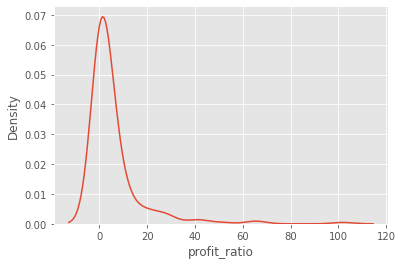

In [129]:
#checking for normal distribution of the sample
sns.kdeplot(horror);

In [114]:
others_sample['profit_ratio'].describe()

count    1366.000000
mean        2.743449
std         3.893189
min         0.000000
25%         0.372774
50%         1.747782
75%         3.533994
max        55.792961
Name: profit_ratio, dtype: float64

In [115]:
#narrowing down "other_sample" to only include profit ratio values
others=others_sample['profit_ratio']

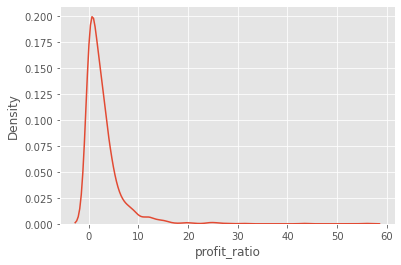

In [130]:
#checking for normal distribution of the sample
sns.kdeplot(others);

In [116]:
# run the one-sided, two-sample t-test
statistic, pvalue = stats.ttest_ind(horror, others, equal_var=False)
pvalue / 2 #here we divide the p-value by two because we are running a one-sided test

0.00018518932745691132

In [117]:
# comparing our final p-value to our alpha value.
(pvalue/2)<alpha

True

### Result: Reject the null hypothesis. Horror films DO have a statistically significant higher profit ratio compared to other genres, on average.

### Recommendation #1: Produce Horror Movies


# 2. Horror Genre - Budget & ROI Hypothesis Test
To dive deeper into the horror genre, we look at low and high budget classes of horror films to see if low budget horror films have a higher return on investement than high budget films, on average. We do so by creating a sample for each budget class of horror films and running a one-sided, two-sample t-test.

In [120]:
#creating samples to run t-test
low_budget_hor = horror_sample.loc[horror_sample['budget_class'] == 'low_budget']
high_budget_hor = horror_sample.loc[horror_sample['budget_class'] == 'high_budget']

In [121]:
# returning the low budget ROI mean
low_budget_hor['profit_ratio'].mean()

7.003820863061332

In [122]:
# returning the high budget ROI mean
high_budget_hor['profit_ratio'].mean()

2.66466076579254

In [123]:
#running the t-test with alpha = 5%
alpha = .05
result = stats.ttest_ind(low_budget_hor['profit_ratio'], high_budget_hor['profit_ratio'])
pval = result[1]/2 #divide by two because we are interested in a one-sided test
print(pval)

0.014233150027950494


In [124]:
#check p-value against our alpha of .05
pval < alpha

True

Result: We reject the null hypothesis as our p-value is lower than our alpha of 5%. Low-Budget horror films have a statistically significant higher profit ratio, on average, compared to High-Budget horror films.
### Recommendation #2: Start by investing in the production of Low-Budget horror films, to minimize your investment risk and help you to break into the film indsutry.
<br>

## Plotting the regression line & Calculating R-squared

To get a visual of the relationship between production budget and profit ratio for horror movies we plot a regression line and calculate the corresponding r-squared value.

In [125]:
#find slope 'm' of regression line
def slope(x, y):
    rho = np.corrcoef(x, y)[0][1]
    s_y = y.std()
    s_x = x.std()

    m = rho * s_y / s_x
    return m
    
m = slope(horror_sample['production_budget'], horror_sample['profit_ratio'])

In [126]:
#find intercept 'c' of regression line
def intercept(m, x, y):
    y_mean = y.mean()
    x_mean = x.mean()

    # calculating intercept estimate
    c = y_mean - m * x_mean
    return c
    
c = intercept(m, horror_sample['production_budget'], horror_sample['profit_ratio'])

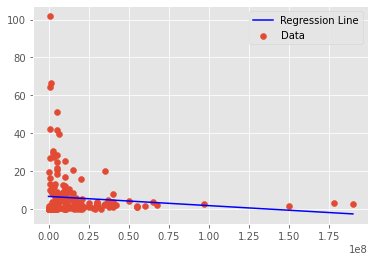

In [127]:
#Plotting the line for ENTIRE HORROR SAMPLE
def best_fit(x, y):
    # Create a scatter plot of x vs. y
    fig, ax = plt.subplots()
    ax.scatter(x, y, label="Data")

    # Calculate coefficient and intercept
    m = slope(x, y)
    c = intercept(m, x, y)
    
    # Plot line created by coefficient and intercept
    regression_line = m * x + c
    ax.plot(x, regression_line, label= "Regression Line", color='red')
    ax.get_lines()[0].set_color("blue")
    ax.legend()
    
best_fit(horror_sample['production_budget'], horror_sample['profit_ratio'])

### Creating a Dataframe for Profit Ratio Means & Budget Tiers for a second regression model

To get an even clearer visual of the relationship between production budget and profit ratio, we plot another regression line of the average profit ratios for the four tiers of production budgets defined by IATSE’s budget tier system.

In [132]:
#create a new column that sorts movies into the four budget tiers
conditions = [
    (horror_sample['production_budget'] <= 7500000),
    (horror_sample['production_budget'] > 7500000) & (horror_sample['production_budget'] <= 11000000),
    (horror_sample['production_budget'] > 1100000) & (horror_sample['production_budget'] <= 15000000),
    (horror_sample['production_budget'] > 15000000)]

#create a list of the values we want to assign for each condition
values = ['tier_1', 'tier_2', 'tier_3', 'tier_4']

#create a new column and use np.select to assign values to it using our lists as arguments
horror_sample['budget_tier'] = np.select(conditions, values)
horror_sample

<ipython-input-132-6368e2704a00>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horror_sample['budget_tier'] = np.select(conditions, values)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,profit_ratio,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,budget_class,Horror,budget_tier
43,69,2013-06-21,World War Z,190000000,202359711,531514650,2013,2.797446,tt0816711,World War Z,World War Z,116.0,"Action,Adventure,Horror",7.0,553751,high_budget,True,tier_4
60,94,2018-08-10,The Meg,178000000,145443742,529530715,2018,2.974892,tt4779682,The Meg,The Meg,113.0,"Action,Horror,Sci-Fi",5.7,114042,high_budget,True,tier_4
106,89,2012-05-11,Dark Shadows,150000000,79727149,238202668,2012,1.588018,tt1077368,Dark Shadows,Dark Shadows,113.0,"Comedy,Fantasy,Horror",6.2,229818,high_budget,True,tier_4
198,12,2017-05-19,Alien: Covenant,97000000,74262031,238521247,2017,2.458982,tt2316204,Alien: Covenant,Alien: Covenant,122.0,"Horror,Sci-Fi,Thriller",6.4,226920,high_budget,True,tier_4
278,65,2012-06-22,Abraham Lincoln: Vampire Hunter,67500000,37519139,137489730,2012,2.036885,tt1611224,Abraham Lincoln: Vampire Hunter,Abraham Lincoln: Vampire Hunter,105.0,"Action,Fantasy,Horror",5.9,142853,high_budget,True,tier_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,35,2013-10-25,Her Cry: La Llorona Investigation,35000,0,0,2013,0.000000,tt2469216,Her Cry: La Llorona Investigation,Her Cry: La Llorona Investigation,89.0,Horror,3.7,70,low_budget,True,tier_1
1580,49,2015-09-01,Exeter,25000,0,489792,2015,19.591680,tt1945044,Exeter,Exeter,91.0,"Horror,Mystery,Thriller",4.5,5156,low_budget,True,tier_1
1585,59,2011-11-25,The Ridges,17300,0,0,2011,0.000000,tt1781935,The Ridges,The Ridges,89.0,"Drama,Horror,Thriller",2.9,127,low_budget,True,tier_1
1588,78,2018-12-31,Red 11,7000,0,0,2018,0.000000,tt7837402,Red 11,Red 11,77.0,"Horror,Sci-Fi,Thriller",5.6,43,low_budget,True,tier_1


In [133]:
#creating dataframe for each budget tier
tier4_hor = horror_sample.loc[horror_sample['budget_tier'] == 'tier_4']
tier3_hor = horror_sample.loc[horror_sample['budget_tier'] == 'tier_3']
tier2_hor = horror_sample.loc[horror_sample['budget_tier'] == 'tier_2']
tier1_hor = horror_sample.loc[horror_sample['budget_tier'] == 'tier_1']

In [139]:
#retrieving the mean ROI for each budget tier
tier4_hor_prm = horror_sample.loc[horror_sample['budget_tier'] == 'tier_4']['profit_ratio'].mean()
tier3_hor_prm = horror_sample.loc[horror_sample['budget_tier'] == 'tier_3']['profit_ratio'].mean()
tier2_hor_prm = horror_sample.loc[horror_sample['budget_tier'] == 'tier_2']['profit_ratio'].mean()
tier1_hor_prm = horror_sample.loc[horror_sample['budget_tier'] == 'tier_1']['profit_ratio'].mean()
print(tier4_hor_prm, tier3_hor_prm, tier2_hor_prm, tier1_hor_prm)

2.66466076579254 5.751416179443601 6.442151812147419 7.235902009870812


In [141]:
#creating a new df of budget tier profit ratio means, to plot
horror_pr_means = {
    'Tiers':[4,3,2,1],
    'PR_Mean':[tier4_hor_prm, tier3_hor_prm, tier2_hor_prm, tier1_hor_prm]}
    
horror_pr_means_df = pd.DataFrame(horror_pr_means)
print(horror_pr_means_df)

   Tiers   PR_Mean
0      4  2.664661
1      3  5.751416
2      2  6.442152
3      1  7.235902


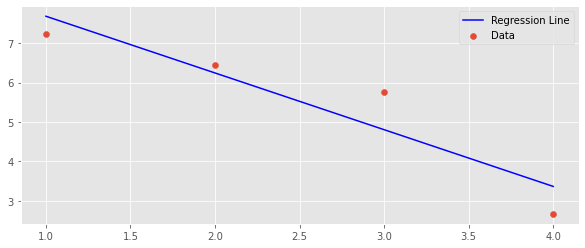

In [143]:
#Plotting Regression Line
def best_fit(x, y):
    # Create a scatter plot of x vs. y
    fig, ax = plt.subplots(figsize=(10,4))
    ax.scatter(x, y, label="Data")

    # Calculate coefficient and intercept
    m = slope(x, y)
    c = intercept(m, x, y)
    
    # Plot line created by coefficient and intercept
    regression_line = m * x + c
    ax.plot(x, regression_line, label= "Regression Line", color='red')
    ax.get_lines()[0].set_color("blue")
    ax.legend()
    
best_fit(horror_pr_means_df['Tiers'], horror_pr_means_df['PR_Mean']);

There is clear linear relationship between average profit ratio and production budget. Average profit ratio of a horror movie decreases as you increase production cost.

### Calculating the corresponding R-squared value

In [144]:
#creating arrays to pass through r-squared function
horror_pr_means_array = horror_pr_means_df['PR_Mean'].array
horror_tier_array = horror_pr_means_df[["Tiers"]] 

In [145]:
from sklearn.linear_model import LinearRegression

#linear regression model
model = LinearRegression()

#define independant and dependant variables
X, y = horror_tier_array, horror_pr_means_array

#regression model fit
model.fit(X, y)

#calculate r-squared of the model
r_squared = model.score(X, y)

print(r_squared)

0.8644524106240016


This high R-squared value further supports the linear regression visual above, where 86.4% of the variability observed in the average profit ratio for a horror movie is explained by the regression model.



# 3. EDA: Relationship between month of release & profit ratio of a horror movie

In [176]:
#Create new column for month
horror_sample['release_date'] = pd.to_datetime(horror_sample['release_date'])
horror_sample['release_month'] = horror_sample['release_date'].dt.month
    

<ipython-input-176-838f0ac0b18b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horror_sample['release_date'] = pd.to_datetime(horror_sample['release_date'])
<ipython-input-176-838f0ac0b18b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horror_sample['release_month'] = horror_sample['release_date'].dt.month


###  Bar Chart Showing All Average Profit Ratios for Horror Movies by Month


In [177]:
#creating a series of profit ratio means for each month of release
mean_by_month = horror_sample.groupby('release_month')['profit_ratio'].mean()
mean_by_month

release_month
1     13.403536
2      5.135730
3      5.245361
4      8.043679
5      5.179842
6      6.202694
7      5.398578
8      4.801439
9      3.593296
10     9.224196
11     1.724143
12     0.654641
Name: profit_ratio, dtype: float64

In [178]:
#convert series to list for plotting purposes
pr_mean_month = mean_by_month.tolist()
pr_mean_month

[13.403535639287698,
 5.135729849356262,
 5.245361484056123,
 8.043678796166546,
 5.179842035100969,
 6.202693885165193,
 5.398577684939367,
 4.801439490577383,
 3.5932958069762826,
 9.224196072482906,
 1.7241426527702703,
 0.6546406716078261]

In [179]:
# creating a list of months in a year for the 'x labels' in barchart below
month_release = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

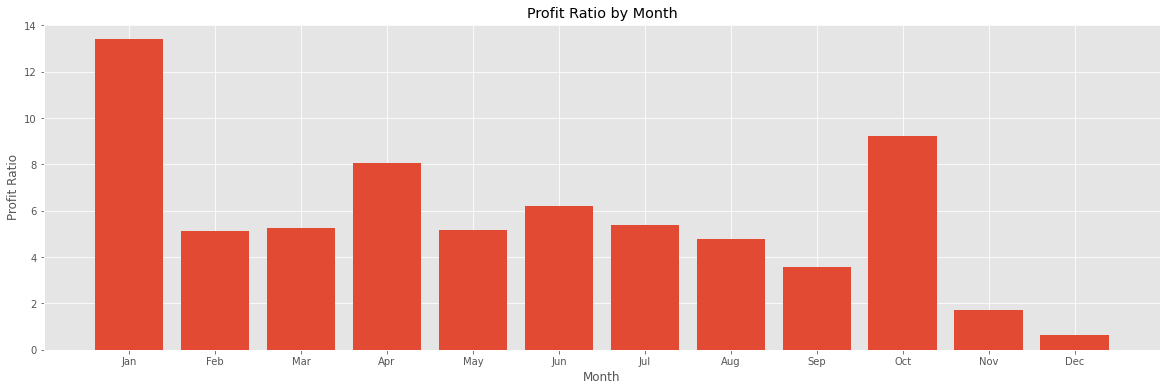

In [180]:
# Bar chart of return on investment by month
plt.figure(figsize=(20, 6))
plt.bar(month_release, pr_mean_month)

plt.xlabel('Month')
plt.ylabel('Profit Ratio')
plt.title('Profit Ratio by Month')
plt.xticks(month_release)

plt.show()

According the above visual, it seems that January and October stand out as the more favorable months to realese a horror movie based on average profit ratio. To test if this difference is statistically significant we must run a One-Way, ANOVA test as there are multiple samples to test.

### ANOVA test for profit ratio based on release month of the horror movie

In [182]:
# One-way ANOVA
result = stats.f_oneway(
    horror_sample[horror_sample['release_month'] == 1]['profit_ratio'],
    horror_sample[horror_sample['release_month'] == 2]['profit_ratio'],
    horror_sample[horror_sample['release_month'] == 3]['profit_ratio'],
    horror_sample[horror_sample['release_month'] == 4]['profit_ratio'],
    horror_sample[horror_sample['release_month'] == 5]['profit_ratio'],
    horror_sample[horror_sample['release_month'] == 6]['profit_ratio'],
    horror_sample[horror_sample['release_month'] == 7]['profit_ratio'],
    horror_sample[horror_sample['release_month'] == 8]['profit_ratio'],
    horror_sample[horror_sample['release_month'] == 9]['profit_ratio'],
    horror_sample[horror_sample['release_month'] == 10]['profit_ratio'],
    horror_sample[horror_sample['release_month'] == 11]['profit_ratio'],
    horror_sample[horror_sample['release_month'] == 12]['profit_ratio']
)

result


F_onewayResult(statistic=1.2374207665553616, pvalue=0.2645954009818483)

Given that our p-value is greater than our alpha of .05, we would fail to reject the null hypothesis. There is not a signficant difference between months. We wanted to dig deeper as the b ar chart we plotted seems to show otherwise. To analyze the difference between specific months we need to run a post-hoc test.
<br>

### Post-Hoc: Tukey's PairWsie Test

In [183]:
#One-way ANOVA
model = ols('profit_ratio ~ C(release_month)', data=horror_sample).fit()
anova_table = sm.stats.anova_lm(model)

print("ANOVA Table:")
print(anova_table)

#Tukey HSD post hoc test
tukey_result = pairwise_tukeyhsd(horror_sample['profit_ratio'], horror_sample['release_month'])

print("Tukey HSD Post Hoc Test:")
print(tukey_result)

ANOVA Table:
                     df        sum_sq     mean_sq         F    PR(>F)
C(release_month)   11.0   2051.756232  186.523294  1.237421  0.264595
Residual          192.0  28941.224670  150.735545       NaN       NaN
Tukey HSD Post Hoc Test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -8.2678 0.6978 -22.2847  5.7491  False
     1      3  -8.1582 0.8174 -23.5129  7.1966  False
     1      4  -5.3599    0.9 -18.9208  8.2011  False
     1      5  -8.2237 0.8764 -24.5919  8.1445  False
     1      6  -7.2008    0.9 -24.5576  10.156  False
     1      7   -8.005 0.8377 -23.3597  7.3498  False
     1      8  -8.6021 0.7208 -23.4692  6.2651  False
     1      9  -9.8102 0.4192 -23.3712  3.7507  False
     1     10  -4.1793    0.9 -17.5588  9.2001  False
     1     11 -11.6794 0.4838 -28.4997  5.1409  False
     1     12 -12.7489 0.1442 -27.2255  1.7277  Fa

### Recommendation #3: This pairwise test supports and reaffirms the conclusion that there is no statistical difference in profit ratios based on month of release of a horror movie. 

- This could be due to sample size of the individual months or due to the fact that the pvalues in the pairwise Tukey HSD are adjusted to adjust for the bias of doing many statistical tests.

In [184]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           profit_ratio   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.237
Date:                Fri, 04 Aug 2023   Prob (F-statistic):              0.265
Time:                        09:16:29   Log-Likelihood:                -794.86
No. Observations:                 204   AIC:                             1614.
Df Residuals:                     192   BIC:                             1654.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 13.4035      3.281      4.085      0.000       6.932      19.876
C(release_month)[T.2]     -8.2678      4.236     -1.952      0.052     -16.623       0.088
C(release_month)[T.3]     -8.1582      4.640     -1.758      0.080     -17.311       0.995
C(release_month)[T.4]     -5.3599      4.098     -1.308      0.192     -13.443       2.724
C(release_month)[T.5]     -8.2237      4.947     -1.662      0.098     -17.981       1.533
C(release_month)[T.6]     -7.2008      5.245     -1.373      0.171     -17.547       3.145
C(release_month)[T.7]     -8.0050      4.640     -1.725      0.086     -17.158       1.148
C(release_month)[T.8]     -8.6021      4.493     -1.915      0.057     -17.464       0.260
C(release_month)[T.9]     -9.8102      4.098     -2.394      0.018     -17.894      -1.727
C(release_month)[T.10]    -4.1793      4.043     -1.034      0.303     -12.155       3.796
C(release_month)[T.11]   -11.6794      5.083     -2.298      0.023     -21.706      -1.653
C(release_month)[T.12]   -12.7489      4.375     -2.914      0.004     -21.378      -4.120
==============================================================================
Omnibus:                      197.531   Durbin-Watson:                   1.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3767.952
Skew:                           3.838   Prob(JB):                         0.00
Kurtosis:                      22.605   Cond. No.                         14.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# january_data = all_recent.loc[all_recent['release_month'] == 1]

# # Create the histogram
# plt.hist(january_data['return_on_investment'], bins=10, alpha=0.7, edgecolor='black')

# plt.xlabel('Return on Investment')
# plt.ylabel('Freq.')
# plt.title('Movie Releases in January')

# plt.show()

#### If you run the above histogram for all the months, you can see that generally they are not normally distributed.

In [ ]:
# #t test comparing one month to the rest of the months combined
# alpha = 0.05
# january = all_recent.loc[all_recent['release_month']==10]
# other_months = all_recent.loc[all_recent['release_month']!=10]

# statistic, pvalue = stats.ttest_ind(january['return_on_investment'], other_months['return_on_investment'], equal_var=False)
# pvalue / 2 #we want our test to be one-sided

In [ ]:
# pvalue/2 < alpha

#### We fail to reject the null: There is no statistical difference in profit ratiobetween January and the rest of the months of the year.



# Conclusion - 3 Recommendations
<br>


1. **Produce Horror Movies -** Based on our in depth analysis, we recommend producing horror movies compared to other genres as on average they provide the highest profit ratio of all movie genres.


2. **Focus on Low-Budget Horror Movies -** Taking it a step further, we recommend producing low-budget horror movies as they return higher profit ratios, on average, than high-budget horror movies. In doing so, you would both minimize your investment risk and lower your inital investment, reducing your barrier to entry to the film industry.


3. **Month of release should not be a primary focus -** Though there seems to be a difference, according to our visuals, that month of release affects profit ratio for a horror movie, there actually is no stastically significant difference between months. **This leads us into our 'Next Steps' in our analysis...**

# Next Steps

1.

2.

3.